## Exercises : data visualisation

In the previous session's exercises on `pandas` we used the *Natural gas consumption in the Netherlands* dataset [CBS Open data StatLine](https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS).  We will continue with the same dataset here for visualisation. We repeat the solution for the last exercise to include the `term` and `date` in our dataframe:


In [7]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

cbs = pd.read_csv("../07_pd/data/00372eng_UntypedDataSet_17032023_161051.csv",sep=";")

def to_ts(s):
    """
    Apply the following timestamp format for each term {JJ,KW,MM}:

    JJ : yyyyJJ00 => 31-12-yyyy
    KW : yyyyKWdd => 01: 1-1-yyyy to 31-3-yyyy
                     02: 1-4-yyyy to 30-6-yyyy
                     03: 1-7-yyyy to 30-9-yyyy
                     04: 1-10-yyyy to 31-12-yyyy
    MM : yyyyMMdd => 1-xx-yyyy

    :param s: {year,term,idx}
    :return: Timestamp
    """

    def last_day(ts):
        """
        Given a timestamp find the last day of the month. The number of days in the month can be
        calculated by subtracting next month from this month on the same day and the same year.

        :param ts:
        :return: Number of days in the month (int).
        """
        return (ts.replace(year=ts.year + (ts.month == 12), month=(ts.month % 12) + 1) - ts).days

    # _main_
    year_, term, idx = s
    match term:
        case 'JJ':
            day_, month_ = 31, 12
            return pd.Timestamp(year=year_, month=month_, day=day_)
        case 'KW':
            day_, month_ = [(31,3),(30,6),(30,9),(31,12)][idx-1]
            return pd.Timestamp(year=year_, month=month_, day=day_)
        case 'MM':
            day_, month_ = last_day(pd.Timestamp(year=year_, month=idx, day=1)), idx
            return pd.Timestamp(year=year_, month=month_, day=day_)

# _main_

df0 = cbs[['Periods','TotalSupply_1']].copy()
df = df0.Periods.str.split(r'(JJ|MM|KW)', regex=True, expand=True)  # expand=True forces the result into a DataFrame
df = pd.DataFrame({'year': df[0].astype(int),                       # Create DataFrame {year,term,idx}
                   'term': df[1],
                   'idx': df[2].astype(int)})

df['date'] = [to_ts(s) for i,s in df.iterrows()] # create the date variable
ngc = pd.concat([df,cbs],axis=1)
ngc.dtypes

year                                               int64
term                                              object
idx                                                int64
date                                      datetime64[ns]
ID                                                 int64
Periods                                           object
TotalSupply_1                                      int64
IndigenousProduction_2                             int64
ProductionFromOtherSources_3                      object
ImportsOfGaseousNaturalGasTotal_4                float64
ImportsViaNorway_5                               float64
ImportsViaGermany_6                              float64
ImportsViaBelgium_7                              float64
ImportsViaUnitedKingdom_8                        float64
ImportsViaDenmark_9                              float64
ImportsOfLiquefiedNaturalGasLng_10               float64
ExportsOfGaseousNaturalGasTotal_11               float64
ExportsToNorway_12             

# Reshape

1) Reshape `ngc` into a long format with all import/export variables as `ie` category and their values as `value` variable. Include only `date` variable from the remainders.


In [8]:
ngc_long = pd.melt(
    ngc,
    id_vars='date',        
    value_vars=[           
        col for col in ngc.columns if col != 'date'
    ],
    var_name='ie',          
    value_name='value'     
)
ngc_long

,date,ie,value
0,1946-12-31,year,1946
1,1947-12-31,year,1947
2,1948-12-31,year,1948
3,1949-12-31,year,1949
4,1950-12-31,year,1950
...,...,...,...
27190,2022-12-31,StorageCapacityLiquefiedNaturalGas_32,535.0
27191,2022-12-31,StorageCapacityLiquefiedNaturalGas_32,535.0
27192,2022-12-31,StorageCapacityLiquefiedNaturalGas_32,535.0
27193,2023-01-31,StorageCapacityLiquefiedNaturalGas_32,535.0


## Line plots

1. Plot lines:

- a) Plot yearly `TotalSupply_1` against `date`.
- b) Draw a horizontal line to mark `TotalSupply_1` at the point where `TotalSupply_1` is just below the latest observation.
- c) On which year does the horizontal line hits the graph.

In [3]:
import matplotlib.pyplot as plt

In [4]:
latest_value = ngc['TotalSupply_1'].iloc[-1]
below_latest = ngc['TotalSupply_1'][ngc['TotalSupply_1'] < latest_value].max()
below_latest

np.int64(3055)

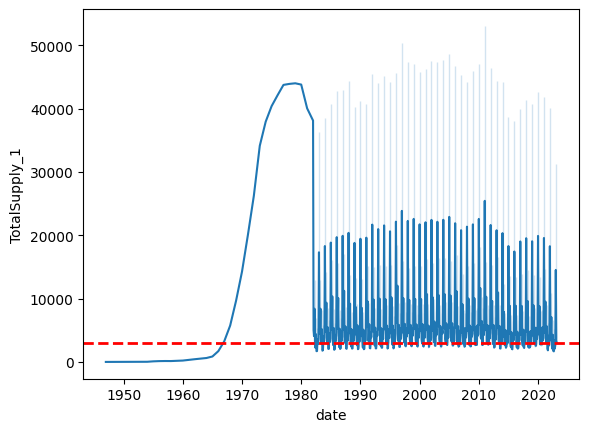

In [11]:
ax = sb.lineplot(ngc, x='date',y='TotalSupply_1')
ax.axhline(y=3055, linewidth=2, color='red', ls='--')

2. The import/export variables are those with names starting with `Import` and `Export`. Plot `TotalSupply_1` against `date` for all import/export variables (Hint: reshape data). Make sure the legend is correctly placed. Set X and Y axis labels to `Year` and `Natural gas (MCM)` respectively and set legend's label to `Import/Export`.


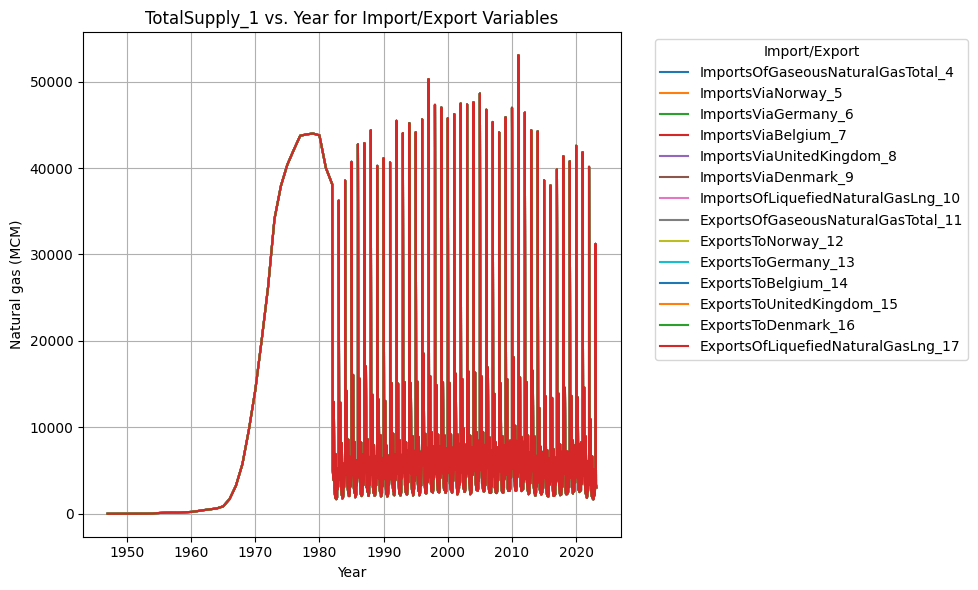

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'ngc' is your DataFrame
# Filter columns that start with 'Import' or 'Export', plus 'date' and 'TotalSupply_1'
import_export_cols = [col for col in ngc.columns if col.startswith(('Import', 'Export'))]
plot_data = ngc[['date', 'TotalSupply_1'] + import_export_cols].copy()

# Reshape the data from wide to long format
melted_data = pd.melt(
    plot_data,
    id_vars=['date', 'TotalSupply_1'],
    value_vars=import_export_cols,
    var_name='Import/Export',
    value_name='Value'
)

# Plot
plt.figure(figsize=(10, 6))
for variable in melted_data['Import/Export'].unique():
    subset = melted_data[melted_data['Import/Export'] == variable]
    plt.plot(subset['date'], subset['TotalSupply_1'], label=variable)

plt.xlabel('Year')
plt.ylabel('Natural gas (MCM)')
plt.title('TotalSupply_1 vs. Year for Import/Export Variables')
plt.legend(title='Import/Export', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent legend overlap
plt.show()

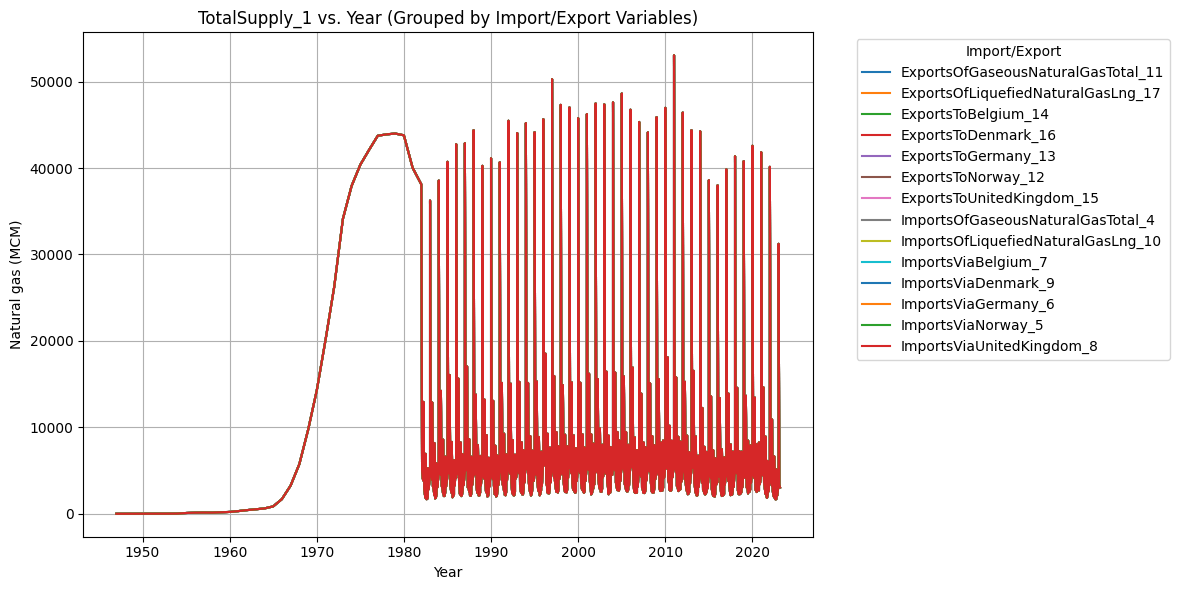

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Filter columns starting with 'Import' or 'Export'
import_export_cols = [col for col in ngc.columns if col.startswith(('Import', 'Export'))]

# 2. Reshape data (long format)
melted_data = pd.melt(
    ngc,
    id_vars=['date', 'TotalSupply_1'],
    value_vars=import_export_cols,
    var_name='Import/Export',
    value_name='Gas_Value'
)

# 3. Plot TotalSupply_1 vs. date, colored by Import/Export variable
plt.figure(figsize=(12, 6))

# Group by 'Import/Export' and plot each line
for name, group in melted_data.groupby('Import/Export'):
    plt.plot(group['date'], group['TotalSupply_1'], label=name)

# Customize plot
plt.xlabel('Year')
plt.ylabel('Natural gas (MCM)')
plt.title('TotalSupply_1 vs. Year (Grouped by Import/Export Variables)')
plt.legend(title='Import/Export', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


3. Plot (point and lines) `TotalSupply_1` against `month` of all time. Note that you will need to summarise (use groupby/sum) on months of the entire dataset. Set X and Y axis labels to `Month` and `Natural gas (MCM)` respectively. Set `Month` axis ticks to represent month abbreviations. Hint: use calendar module to get month abbreviations. Hint: use the `term` variable to filter only `MM` observations.

4. Plot boxplots of `TotalSupply_1` against `month` of all time. Set X and Y axis labels to `Month` and `Natural gas (MCM)` respectively. Set `Month` axis ticks to represent month abbreviations.

In [ ]:
# ...

5) Boxplots of import/export variables against `TotalSupply_1`. Set X and Y axis labels to `Natural gas (MCM)` and `Import/Export` respectively.

In [ ]:
# ...